In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Adile Gündoğdu
#   E-mail: adilegundogdu34@gmail.com

# Showcase of the algorithms for deblurring and denoising

In this notebook, we are going to investigate the Total Variation Algorithms, Gradient Descent and FISTA on 4 different cases with 2 types of noises. Firstly, we build an inverse problem; thus, we will blur the image and then add noise. Next, we will try to fix the picture we've distorted and finally, we will compare the results. 

If you have any questions, please do not hesitate to contact with me! 


## Table of Contents;
* [Import algorithms, operators and functions](#chapter1)
* [A. Setting up the direct problem](#chapter2)
    * [The Deblurring Problem](#section_2_1)
    * [The Denoising Problem](#section_2_2)
        * [Different Noises: Gaussian Noise](#sub_section_2_2_1)
            * [Total variation deblurring](#sub_sub_section_2_2_1_1) 
            * [Total variation denoising](#sub_sub_section_2_2_1_2)
            * [Gradient Descent](#sub_sub_section_2_2_1_3) 
            * [FISTA](#sub_sub_section_2_2_1_4)
        * [Different Noises: Salt and Pepper Noise](#sub_section_2_2_2)
            * [Total variation deblurring](#sub_sub_section_2_2_2_1) 
            * [Total variation denoising](#sub_sub_section_2_2_2_2)
* [Deblurring algorithm to noise image](#chapter3)
* [Denoising algorithm to blurred image](#chapter4)
* [Different $\alpha$'s for TV denoising](#chapter5)

## Import algorithms, operators and functions <a class="anchor" id="chapter1"></a>
First, we import all tools needed:

In [2]:
# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator, BlurringOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction
from cil.utilities import dataexample, noise


# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL display function
from cil.utilities.display import show2D


# Import FBP from CIL recon class
from cil.recon import FBP

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.framework import ImageGeometry, ImageData

# All external imports
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image as mpimg

import cil
print(cil.__version__)

astropy module not found


22.1.0


## A. Setting up the direct problem <a class="anchor" id="chapter2"></a>

To set the direct problem, first, we need to upload the image. Since I usually work with gray images, I have to turn my colored images into gray images. Hence, the way of turning the gray is using the RGB(red-green-blue) method which is changing the intensity of the color with a value between 0 and 255. We are going to change the last three channels of the image.

*PS:* I wanted to use images other than the data folder, so I uploaded them. The first thing we need to set is RGB(red-green-blue) color model.

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


If you want to use different image, you can use the other options.

In [4]:
impath = 'pics/cartoon_image.png'
#impath = 'pics/cartoon_image2.jfif'
#impath = 'pics/maidens_tower.jpg'
#impath = 'pics/tower.jpg'

Now, we are taking the image as a array with float32 datatype.

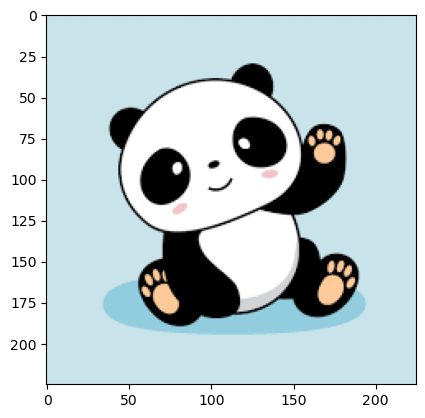

In [5]:
im = mpimg.imread(impath) 
im_rgb = np.array(im[:,:,0:3], dtype=np.float32)
plt.imshow(im_rgb)

We added the colored images, so we might need to turn them into gray images.

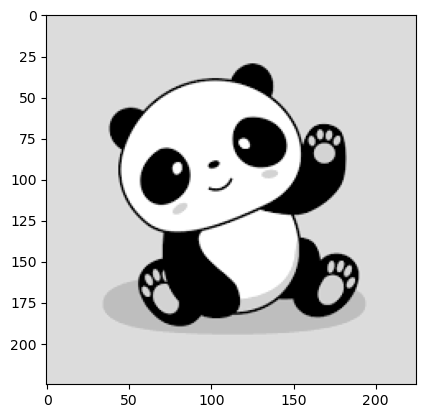

In [6]:
im_gray = rgb2gray(im_rgb)
plt.imshow(im_gray, cmap='gray')

In [7]:
ig = ImageGeometry(voxel_num_x=im.shape[1], voxel_num_y=im.shape[0])
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x225,y225
voxel_size : x1.0,y1.0
center : x0,y0



In [8]:
im_gray_cil = ImageData(im_gray, geometry=ig)

 We need to define a plotting function for the use same range and size all the time.

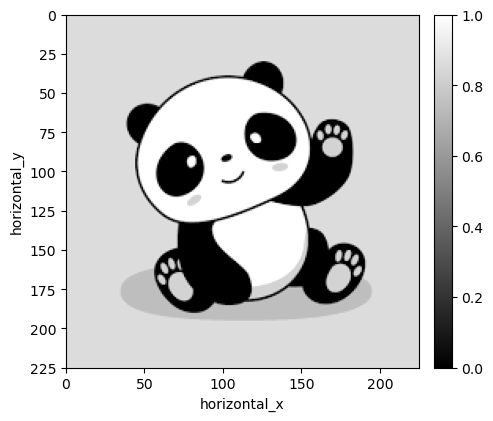

In [9]:
myshow = lambda image : show2D(image, origin="upper", size=(8,8), fix_range=(0,1))
myshow(im_gray_cil)

### The Deblurring Problem <a class="anchor" id="section_2_1"></a>

We consider the deblurring problem

$$ d = A u + \eta$$

where 
- $u$ is the unknown sharp image
- $A$ is a linear operator representing blurring
- $\eta$ is additive Gaussian noise
- $d$ is the blurred and noisy image.

To set up the direct problem we specify a *point spread function (PSF)* to blur the image through a convolution:

In [10]:
# Parameters for point spread function PSF (size and std)
ks          = 5; 
ksigma      = 2;

# Create 1D PSF and 2D as outer product, then normalise.
w           = np.exp(-np.arange(-(ks-1)/2,(ks-1)/2+1)**2/(2*ksigma**2))
w.shape     = (ks,1)
PSF         = w*np.transpose(w)
PSF         = PSF/(PSF**2).sum()
PSF         = PSF/PSF.sum()

For the blurring, CIL has a specify Blurring Operator and we use it, then we apply it to the test image and display it.

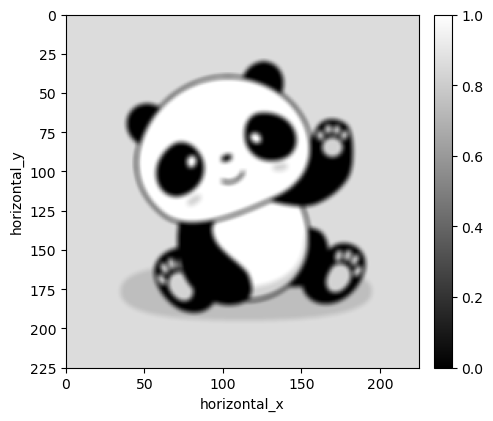

In [11]:
A = BlurringOperator(PSF, ig)
im_blur = A.direct(im_gray_cil)
myshow(im_blur)

### The Denoising Problem <a class="anchor" id="section_2_2"></a>

For the denoising part of this problem, we want to compare the different noises and their results. So, we add Gaussian and Salt-and-Pepper noise.

#### Different Noises: Gaussian Noise <a class="anchor" id="sub_section_2_2_1"></a>

We add Gaussian noise to the blurred image.

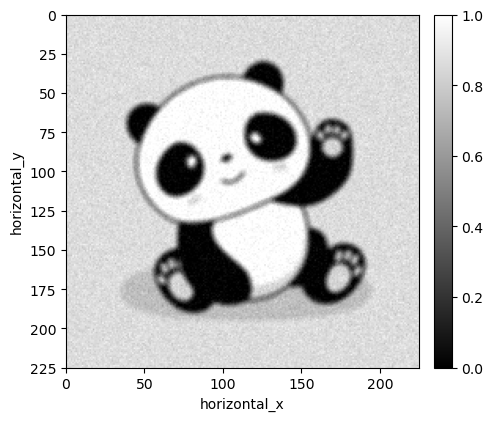

In [12]:
im_blur_noise_gaussian = noise.gaussian(im_blur, seed=10, var=0.001)
myshow(im_blur_noise_gaussian)

#### Total variation deblurring  <a class="anchor" id="sub_sub_section_2_2_1_1"></a>

We formulate the image deblurring problem as an optimization problem to simultaneously fit to the data and enforce regularization on the solution. We use a simple least squares data-fitting term with the blurring operator and try out a few different regularizers $\Psi(u)$ in the general form optimization problem:

$$
\min_u  \| A u - d\|^{2}_{2} + \alpha\,\Psi(u)
$$



We will try to solve this minimization problem.

$$\begin{equation}
\underset{u}{\operatorname{argmin}} \frac{1}{2} \| A u - g\|^{2}_{2} + \alpha\,\mathrm{TV}(u)
\end{equation}$$

where,

* g is a noisy data corrupted with Gaussian noise,
* $A$ is a Blurring operator,
* TV stands for the Total variation regulariser.


Once set up, we can then run it for some iterations and inspect the preliminary resulting image:

In [13]:
alpha = 0.01
G = alpha * TotalVariation(max_iteration=10, backend='numpy')
F = LeastSquares(A, im_blur_noise_gaussian)

fista = FISTA(initial = ig.allocate(0), f = F, g = G, 
              max_iteration = 200, update_objective_interval = 50)
fista.run()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          3.29465e+04
       50        200         0.155          5.70350e+01
      100        200         0.142          5.70320e+01
      150        200         0.138          5.70319e+01
      200        200         0.137          5.70319e+01
-------------------------------------------------------
      200        200         0.137          5.70319e+01
Stop criterion has been reached.



We clearly see that TV deblurring works on the blurred image very well even if it(the panda image) has noise.
 

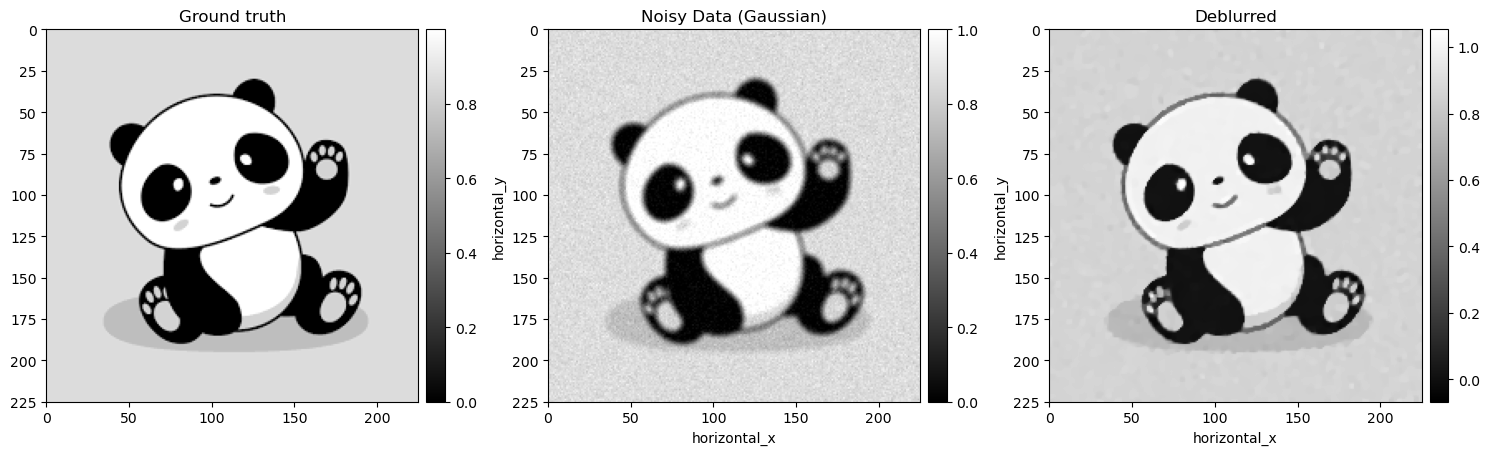

In [14]:
show2D([im_gray, im_blur_noise_gaussian, fista.solution], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Deblurred'], 
       origin="upper", num_cols=3)

#### Total variation denoising  <a class="anchor" id="sub_sub_section_2_2_1_2"></a>

$$\begin{equation}
\underset{u}{\operatorname{argmin}} \frac{1}{2} \| u - g\|^{2}_{2} + \alpha \mathrm{TV}(u)
\end{equation}$$

where,

* g is a noisy data corrupted with Gaussian noise,
* TV stands for the Total variation regulariser.

In [15]:
alpha = 0.05
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV = TV.proximal(im_blur_noise_gaussian, tau=0.5)
#we can change tau and see the differences.

In this case, we see that the TV denoising algorithm works well; however, TV denoising thinks that thin lines and small points are noise, so it tries to delete these parts.

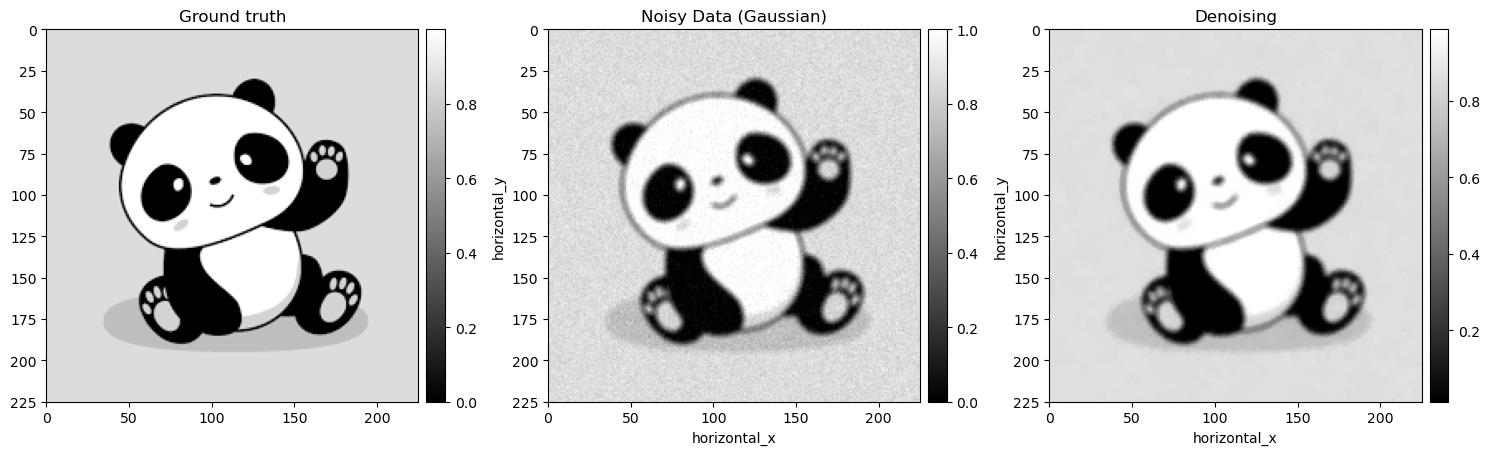

In [16]:
show2D([im_gray, im_blur_noise_gaussian, proxTV], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising'], 
       origin="upper", num_cols=3)

The result for TV deblurring and TV denoising.

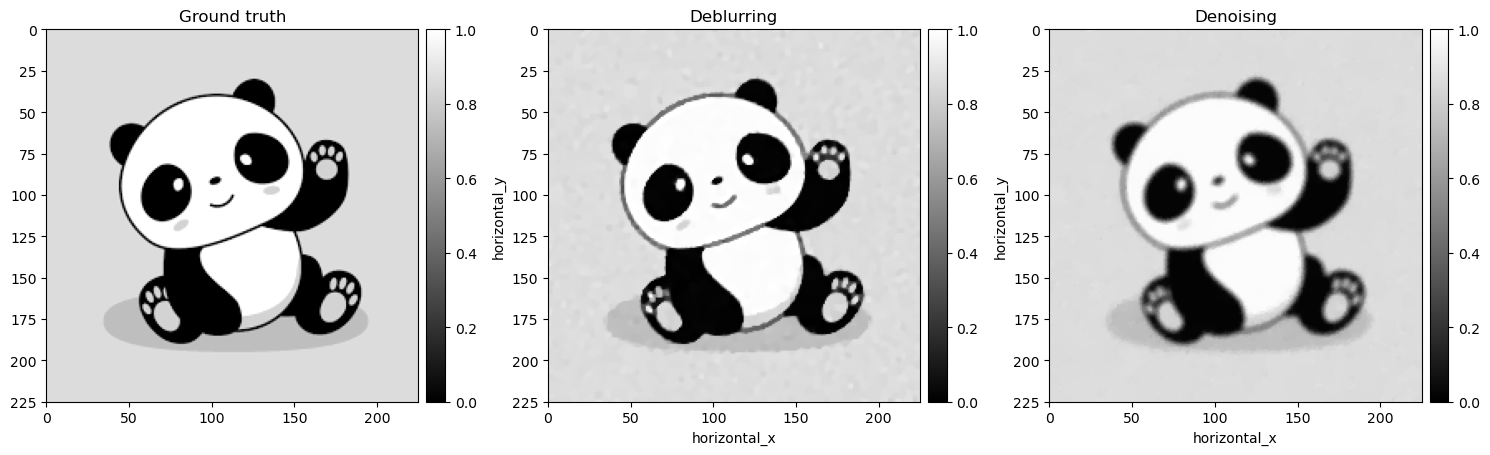

In [17]:
show2D([im_gray, fista.solution, proxTV], 
       title=['Ground truth', 'Deblurring', 'Denoising'], 
       origin="upper", num_cols=3, fix_range = (0,1))

#### Gradient Descent  <a class="anchor" id="sub_sub_section_2_2_1_3"></a>

The choice of $\Psi(u)$ determines the regularization to apply. We first try without regularization, $\Psi(u) = 0$, leaving us with the simpler least-squares optimization problem
$$
\min_u  \| A u - d\|^{2}_{2}
$$

We set up a *LeastSquares* function object(F):

In [18]:
F = LeastSquares(A, im_blur_noise_gaussian)
x0 = ig.allocate(0.0)

In [19]:
s_x = 50
s_y = 60
slices = [('horizontal_x',s_x),('vertical',s_y)]

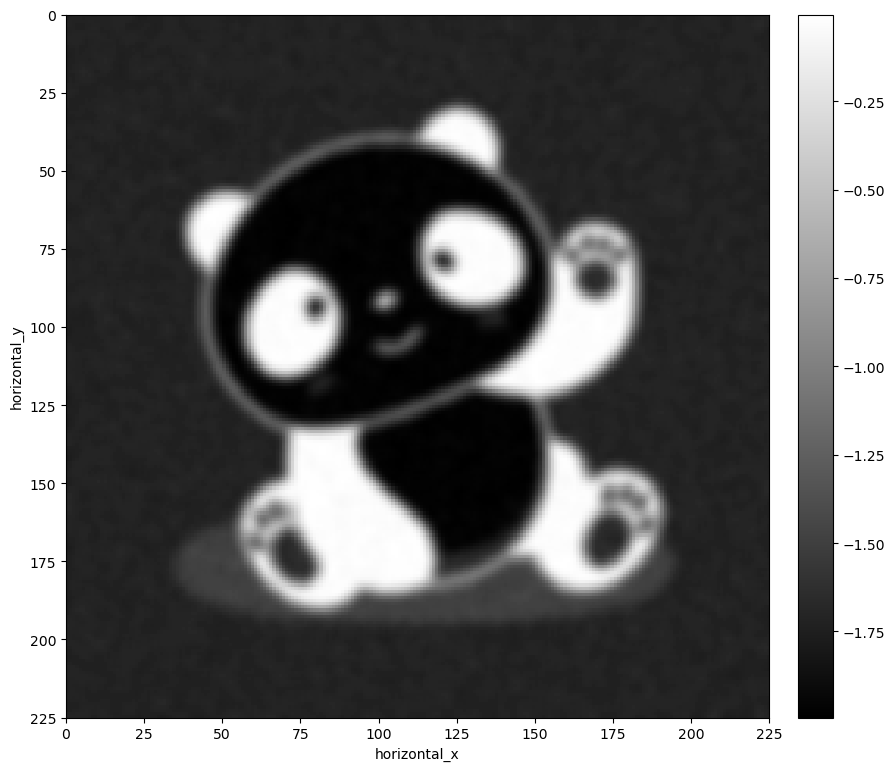

In [20]:
show2D(F.gradient(x0),slice_list=slices,origin='upper-left')

In [21]:
myGD_LS = GD(initial=x0, 
             objective_function=F, 
             step_size=None, 
             max_iteration=1000, 
             update_objective_interval=50)

myGD_LS.run(300, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.29465e+04
       50       1000         0.012          3.21361e+01
      100       1000         0.011          2.86839e+01
      150       1000         0.011          2.67078e+01
      200       1000         0.011          2.53727e+01
      250       1000         0.011          2.43814e+01
      300       1000         0.011          2.35989e+01
-------------------------------------------------------
      300       1000         0.011          2.35989e+01
Stop criterion has been reached.



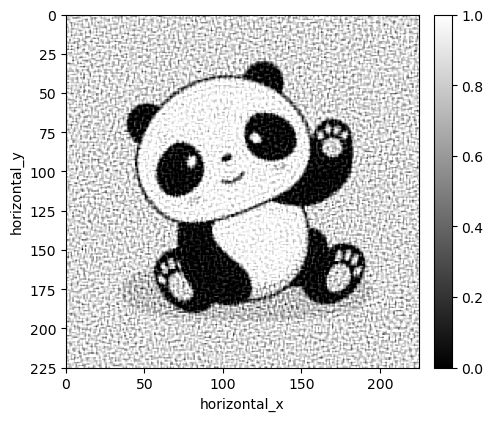

In [22]:
myshow(myGD_LS.solution)

Using CGLS to solve the Tikhonov problem with gradient operator D, i.e.,  
$$\min_u \|Au-b\|_2^2 + \alpha^2\|Du\|_2^2$$

In [23]:
F = LeastSquares(A, im_blur_noise_gaussian)
D = GradientOperator(ig, backend = 'numpy')
alpha = 2.0
F_reg = OperatorCompositionFunction(L2NormSquared(),D)
Full = F + (alpha**2)*F_reg

In [24]:
myGD_tikh = GD(initial=x0, 
               objective_function=Full, 
               step_size=None, 
               max_iteration=1000, 
               update_objective_interval = 30)
myGD_tikh.run(200, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.29465e+04
       30       1000         0.018          5.27404e+02
       60       1000         0.017          5.26131e+02
       90       1000         0.016          5.26101e+02
      120       1000         0.016          5.26100e+02
      150       1000         0.015          5.26100e+02
      180       1000         0.015          5.26100e+02
-------------------------------------------------------
      200       1000         0.015                     
Stop criterion has been reached.



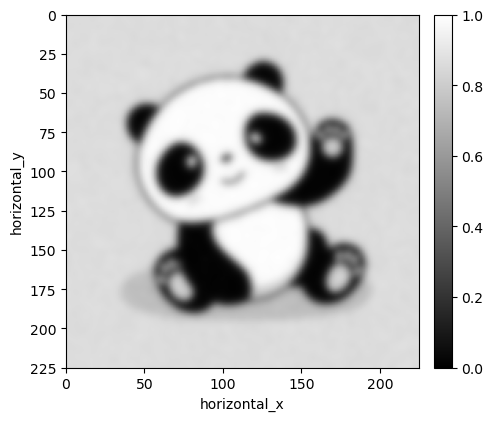

In [25]:
myshow(myGD_tikh.solution)

#### FISTA <a class="anchor" id="sub_sub_section_2_2_1_4"></a>

In [26]:
F = LeastSquares(A, im_blur_noise_gaussian)
G = IndicatorBox(lower=0.0)

In [27]:
myFISTANN = FISTA(f=F, 
                  g=G, 
                  initial=x0, 
                  max_iteration=1000,
                  update_objective_interval = 50)

myFISTANN.run(300, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.29465e+04
       50       1000         0.017          2.33106e+01
      100       1000         0.017          1.87001e+01
      150       1000         0.017          1.64910e+01
      200       1000         0.017          1.54052e+01
      250       1000         0.018          1.48823e+01
      300       1000         0.017          1.46247e+01
-------------------------------------------------------
      300       1000         0.017          1.46247e+01
Stop criterion has been reached.



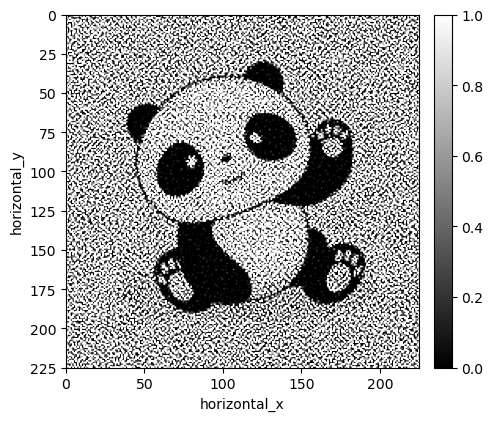

In [28]:
myshow(myFISTANN.solution)

#### The results

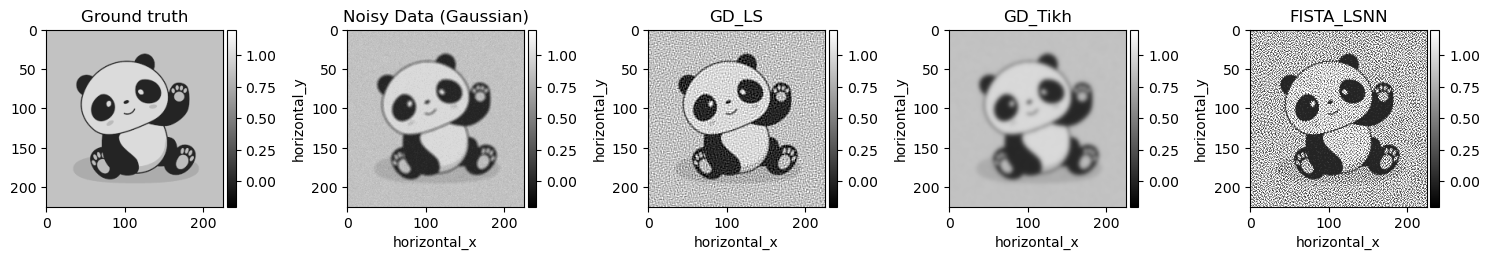

In [29]:
show2D([im_gray, im_blur_noise_gaussian, myGD_LS.solution, myGD_tikh.solution, myFISTANN.solution], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'GD_LS', 'GD_Tikh', 'FISTA_LSNN'], 
       origin="upper", num_cols=5, fix_range =(-0.2,1.2))

#### Different Noises: Salt and Pepper Noise  <a class="anchor" id="sub_section_2_2_2"></a> 

Now, we use another noise which is Salt-and-Pepper noise.

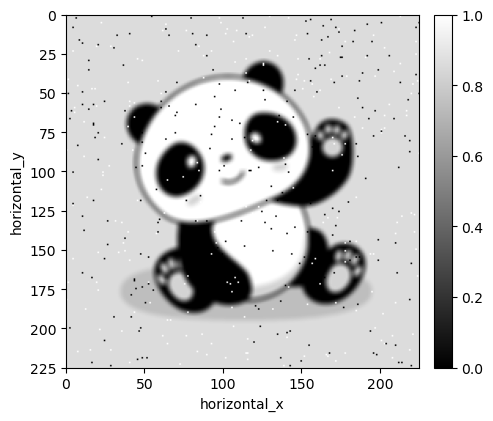

In [30]:
im_blur_noise_saltnpepper = noise.saltnpepper(im_blur, amount=0.01, seed = 10)
myshow(im_blur_noise_saltnpepper)

#### Total variation deblurring  <a class="anchor" id="sub_sub_section_2_2_2_1"></a>

In [31]:
alpha = 0.5
G = alpha * TotalVariation(max_iteration=10, backend='numpy')
F = LeastSquares(A, im_blur_noise_saltnpepper)

fista_saltnpepper = FISTA(initial = ig.allocate(0), f = F, g = G, 
              max_iteration = 200, update_objective_interval = 50)
fista_saltnpepper.run()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          3.29618e+04
       50        200         0.130          8.34665e+02
      100        200         0.129          8.34665e+02
      150        200         0.129          8.34665e+02
      200        200         0.129          8.34665e+02
-------------------------------------------------------
      200        200         0.129          8.34665e+02
Stop criterion has been reached.



When I choose $\alpha$ as 0.001, then the result is divergent.

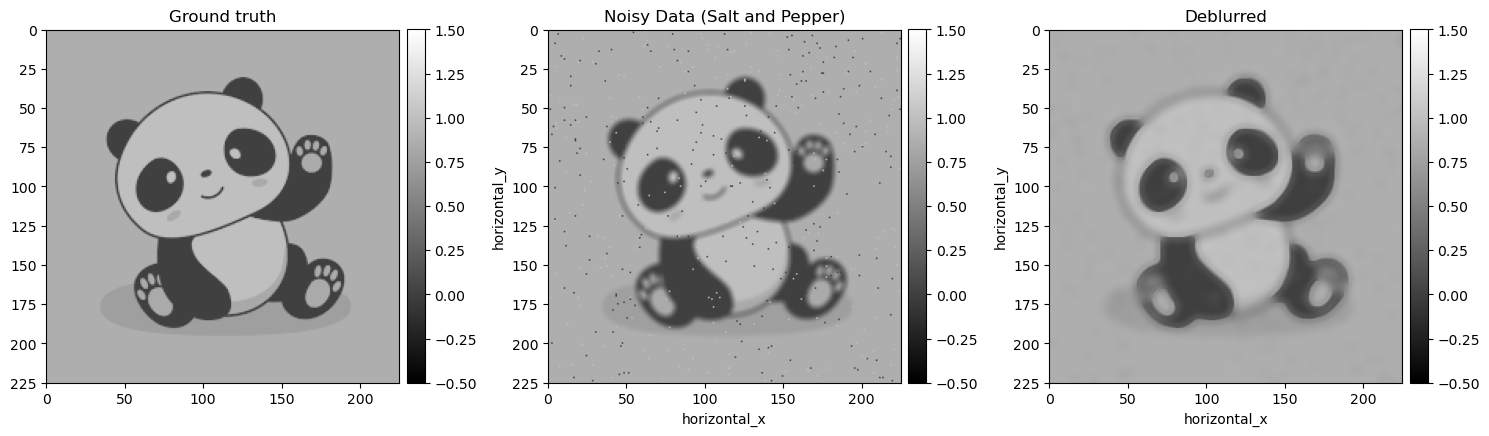

In [32]:
show2D([im_gray, im_blur_noise_saltnpepper, fista_saltnpepper.solution], 
       title=['Ground truth', 'Noisy Data (Salt and Pepper)', 'Deblurred'], 
       origin="upper", num_cols=3, fix_range= (-0.5,1.5))

#### Total variation denoising  <a class="anchor" id="sub_sub_section_2_2_2_2"></a>

In [33]:
alpha = 0.1
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_saltnpepper = TV.proximal(im_blur_noise_saltnpepper, tau=1.0)
#we can change tau and see the differences.

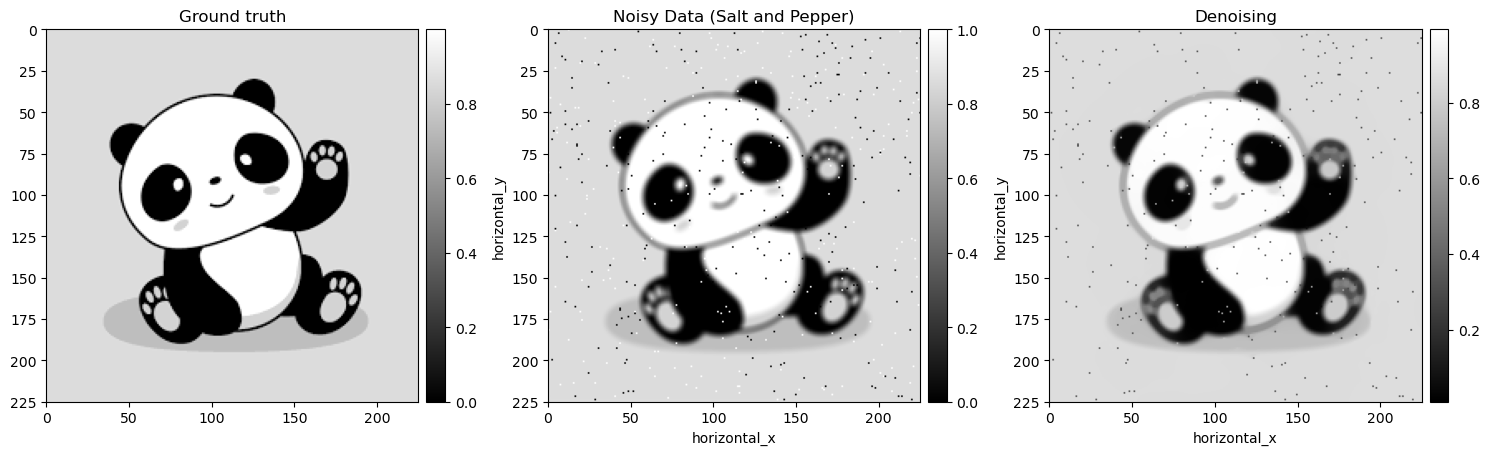

In [34]:
show2D([im_gray, im_blur_noise_saltnpepper, proxTV_saltnpepper], 
       title=['Ground truth', 'Noisy Data (Salt and Pepper)', 'Denoising'], 
       origin="upper", num_cols=3)

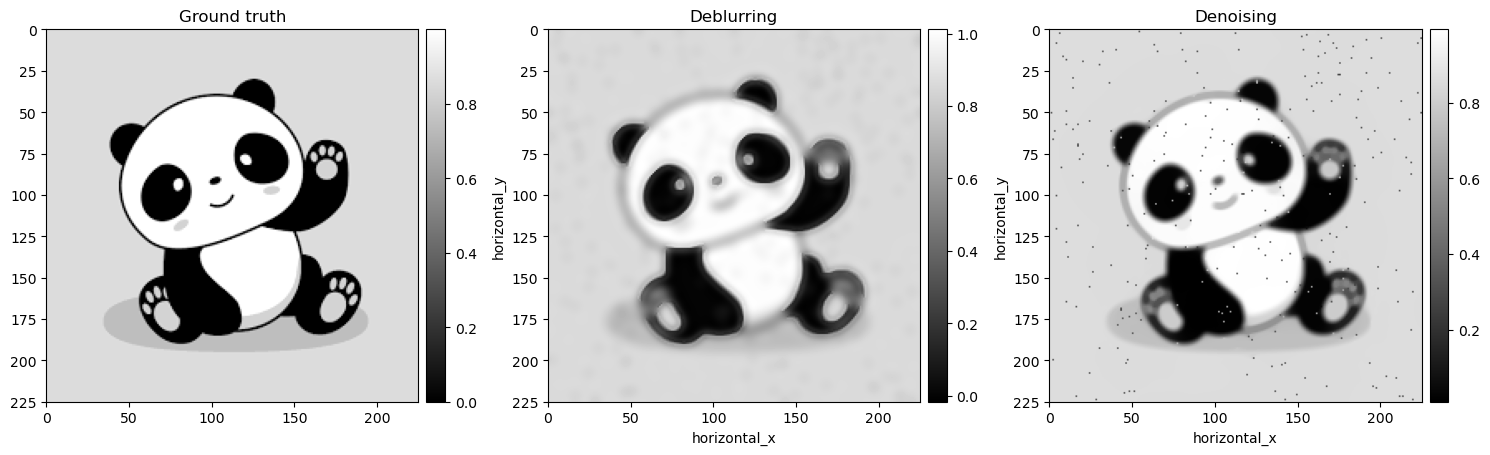

In [35]:
show2D([im_gray, fista_saltnpepper.solution, proxTV_saltnpepper], 
       title=['Ground truth', 'Deblurring', 'Denoising'], 
       origin="upper", num_cols=3)

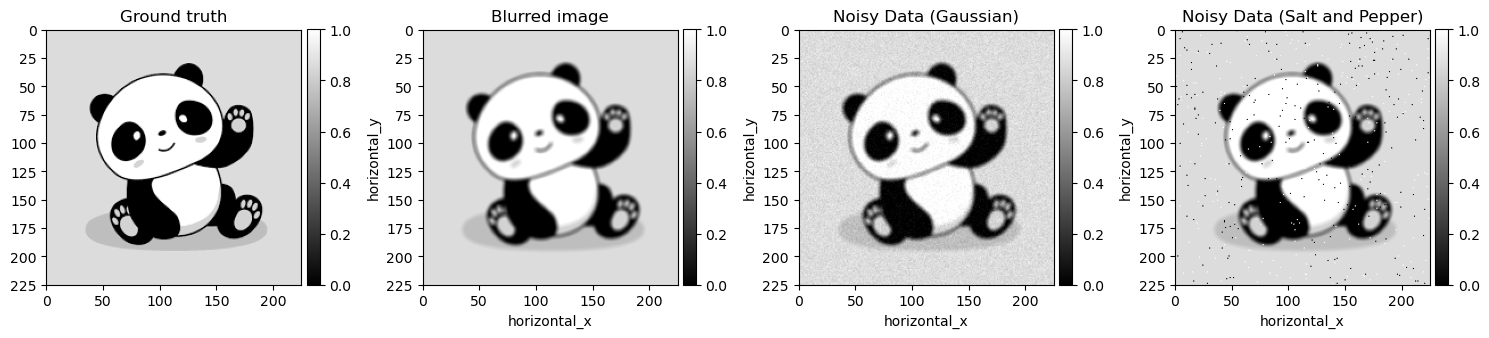

In [36]:
show2D([im_gray, im_blur, im_blur_noise_gaussian, im_blur_noise_saltnpepper], 
       title=['Ground truth', 'Blurred image', 'Noisy Data (Gaussian)','Noisy Data (Salt and Pepper)',], 
       origin="upper", num_cols=4, fix_range = (0,1))

## Deblurring algorithms to noise image <a class="anchor" id="chapter3"></a>

I will try to TV deblurring algorithm only with noise image. 

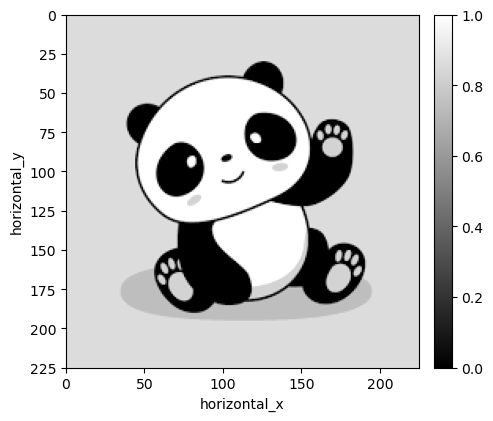

In [37]:
im_gray_cil = ImageData(im_gray, geometry=ig)
myshow = lambda image : show2D(image, origin="upper", size=(8,8), fix_range=(0,1))
myshow(im_gray_cil)

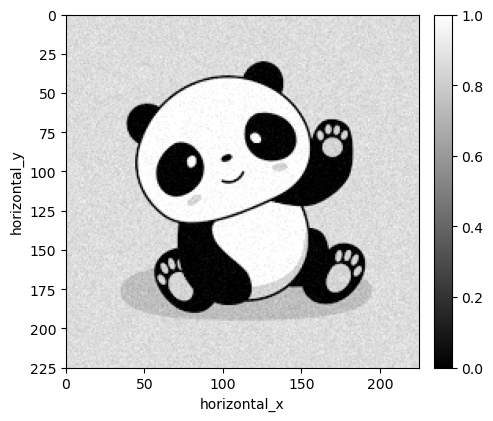

In [38]:
im_blur_noise_gaussian = noise.gaussian(im_gray_cil, seed=10, var=0.001)
myshow(im_blur_noise_gaussian)

I wonder whether the deblurring algorithm works only with noise data.

In [39]:
alpha = 0.01
G = alpha * TotalVariation(max_iteration=10, backend='numpy')
F = LeastSquares(A, im_blur_noise_gaussian)

fista = FISTA(initial = ig.allocate(0), f = F, g = G, 
              max_iteration = 200, update_objective_interval = 50)
fista.run()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          3.36490e+04
       50        200         0.130          2.53614e+02
      100        200         0.130          2.53441e+02
      150        200         0.130          2.53429e+02
      200        200         0.130          2.53426e+02
-------------------------------------------------------
      200        200         0.130          2.53426e+02
Stop criterion has been reached.



FISTA is not a suitable algorithm for only noisy data.

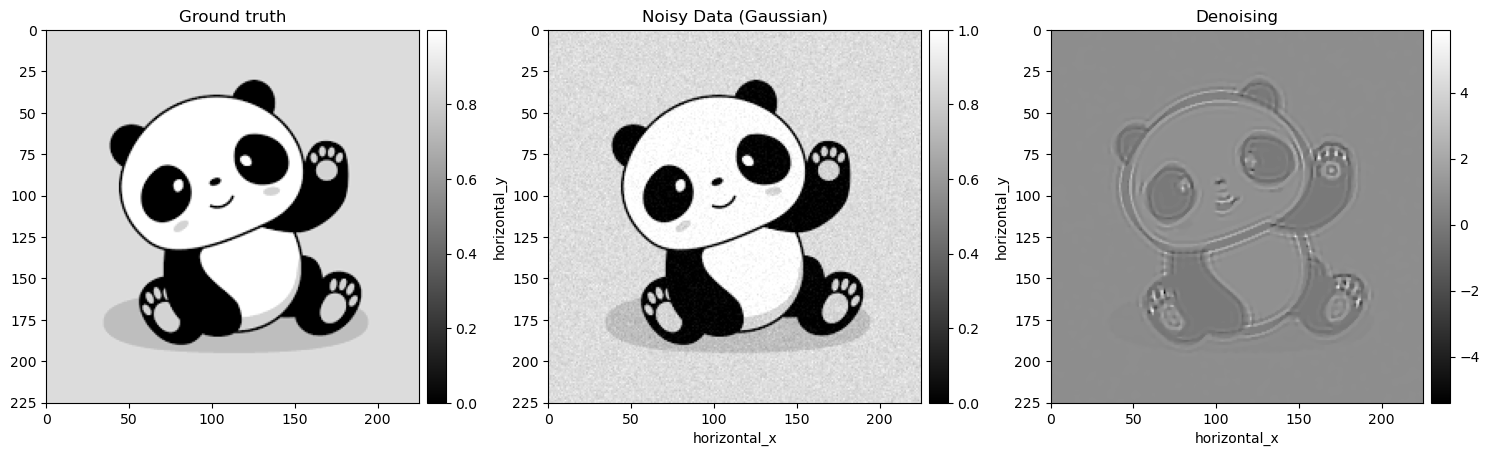

In [40]:
show2D([im_gray, im_blur_noise_gaussian, fista.solution], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising'], 
       origin="upper", num_cols=3)

In [41]:
alpha = 0.05
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV = TV.proximal(im_blur_noise_gaussian, tau=0.5)
#we can change tau and see the differences.

When we use only noisy image for the proxTV, we see that it works well.

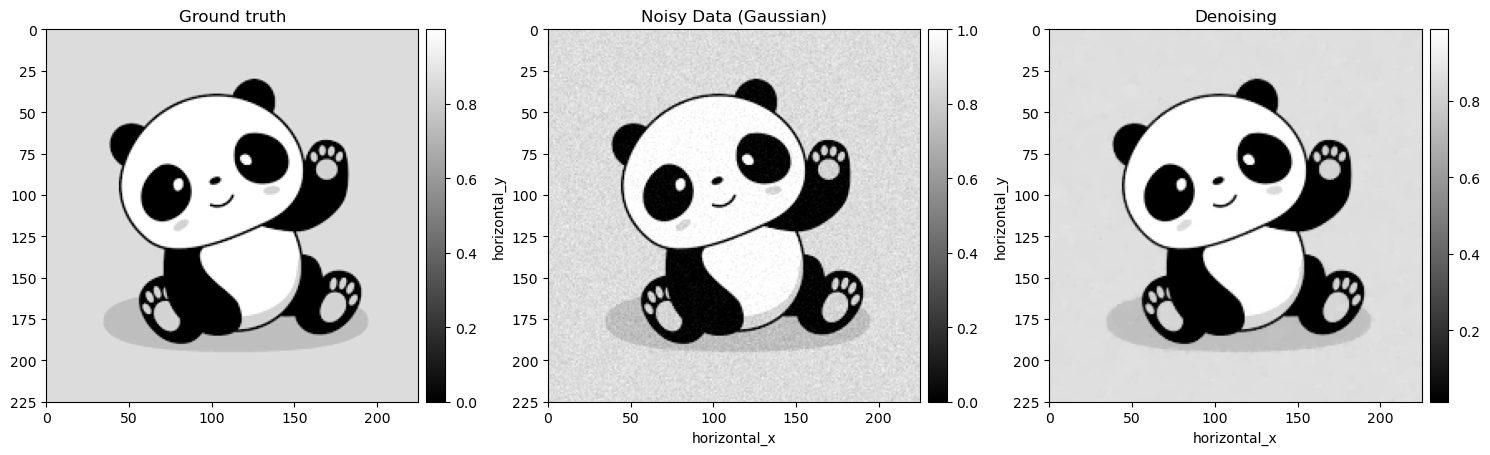

In [42]:
show2D([im_gray, im_blur_noise_gaussian, proxTV], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising'], 
       origin="upper", num_cols=3)

## Denoising algorithms to blurred image <a class="anchor" id="chapter4"></a>

I will try to TV denoising algorithm only with blurred image.

In [43]:
# Parameters for point spread function PSF (size and std)
ks          = 5; 
ksigma      = 2;

# Create 1D PSF and 2D as outer product, then normalise.
w           = np.exp(-np.arange(-(ks-1)/2,(ks-1)/2+1)**2/(2*ksigma**2))
w.shape     = (ks,1)
PSF         = w*np.transpose(w)
PSF         = PSF/(PSF**2).sum()
PSF         = PSF/PSF.sum()

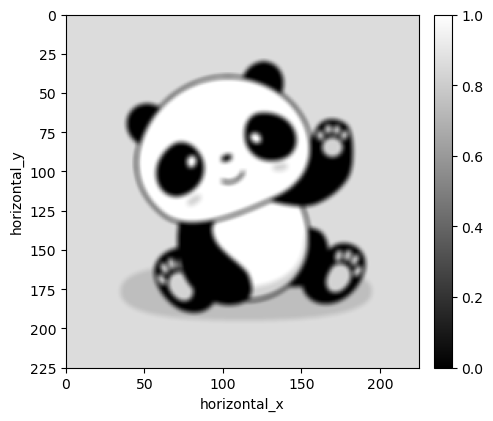

In [44]:
A = BlurringOperator(PSF, ig)
im_blur = A.direct(im_gray_cil)
myshow(im_blur)

In [45]:
alpha = 0.05
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV = TV.proximal(im_blur, tau=0.5)
#we can change tau and see the differences.

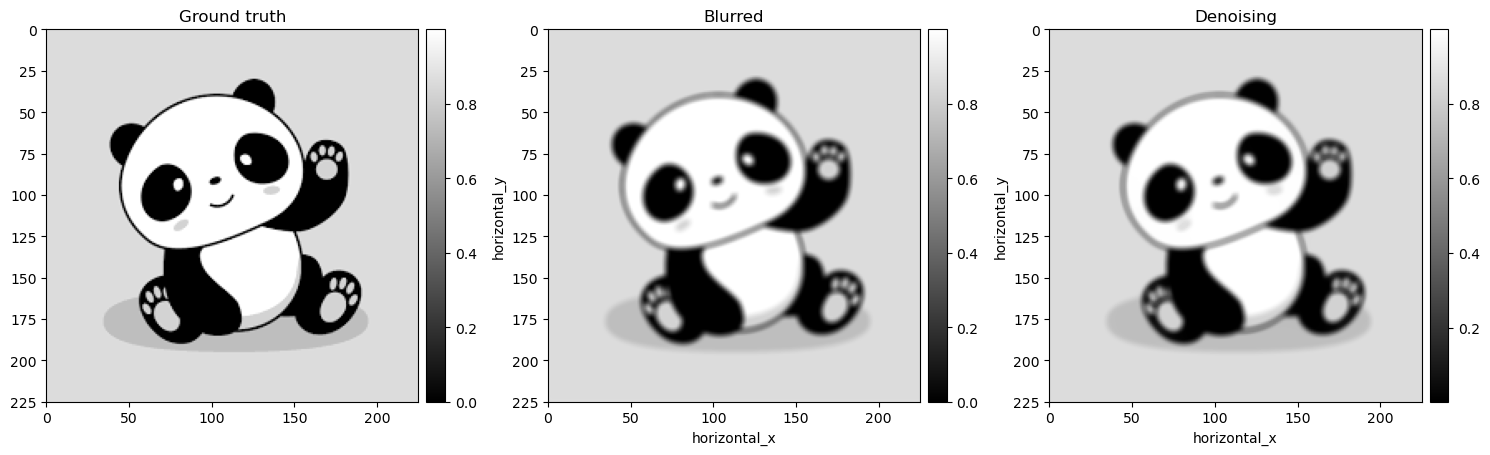

In [46]:
show2D([im_gray, im_blur, proxTV], 
       title=['Ground truth', 'Blurred', 'Denoising'], 
       origin="upper", num_cols=3)

## Different $\alpha$'s for TV denoising <a class="anchor" id="chapter5"></a>

$$\begin{equation}
\underset{u}{\operatorname{argmin}} \frac{1}{2} \| u - g\|^{2}_{2} + \alpha \mathrm{TV}(u)
\end{equation}$$

where,

* g is a noisy data corrupted with Gaussian noise,
* TV stands for the Total variation regulariser.
* $\alpha$ is penalty.

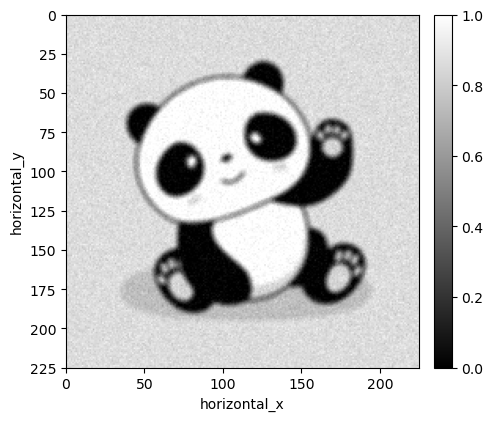

In [47]:
im_blur_noise_gaussian = noise.gaussian(im_blur, seed=10, var=0.001)
myshow(im_blur_noise_gaussian)

If above code doesn't run, then go to the Gaussian Noise part and run that line. 

When $\alpha$ is so small;

In [48]:
alpha = 0.00001
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_1 = TV.proximal(im_blur_noise_gaussian, tau=1)

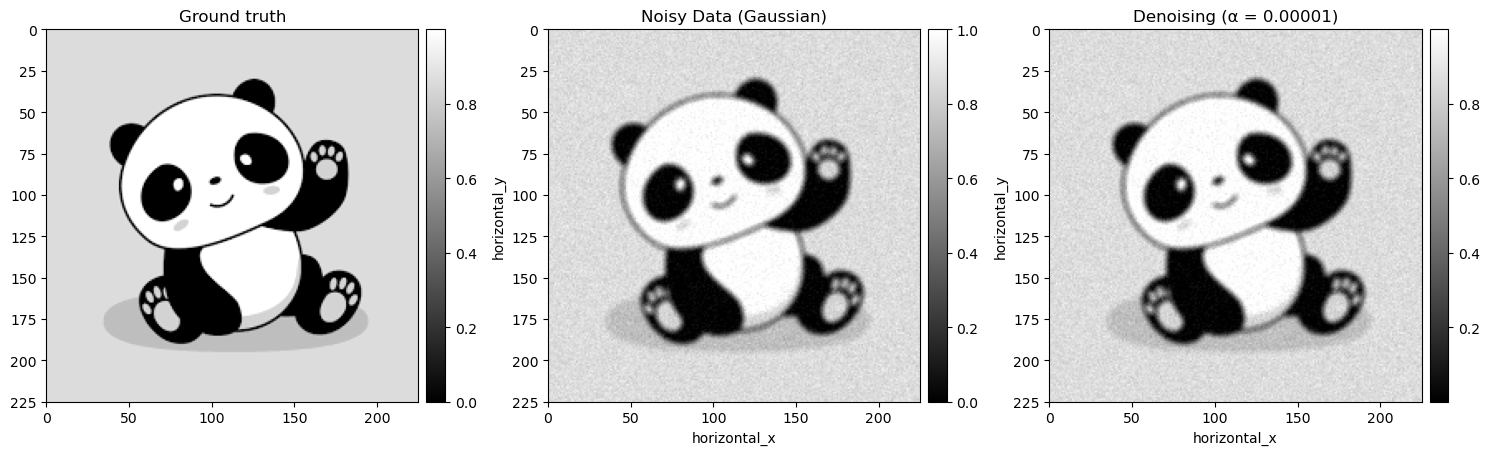

In [49]:
show2D([im_gray, im_blur_noise_gaussian, proxTV_1], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising (\u03B1 = 0.00001)'], 
       origin="upper", num_cols=3)

When $\alpha$ is small;

In [50]:
alpha = 0.001
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_2 = TV.proximal(im_blur_noise_gaussian, tau=1.0)

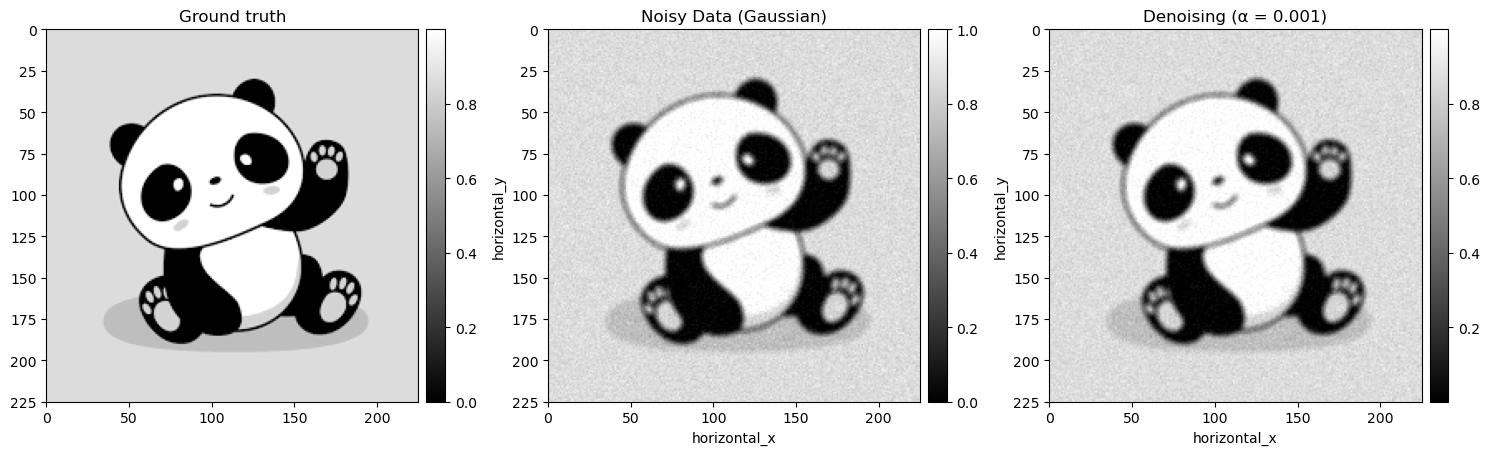

In [51]:
show2D([im_gray, im_blur_noise_gaussian, proxTV_2], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising (\u03B1 = 0.001)'], 
       origin="upper", num_cols=3)

When $\alpha$ is optimal;

In [52]:
alpha = 0.1
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_3 = TV.proximal(im_blur_noise_gaussian, tau=1)

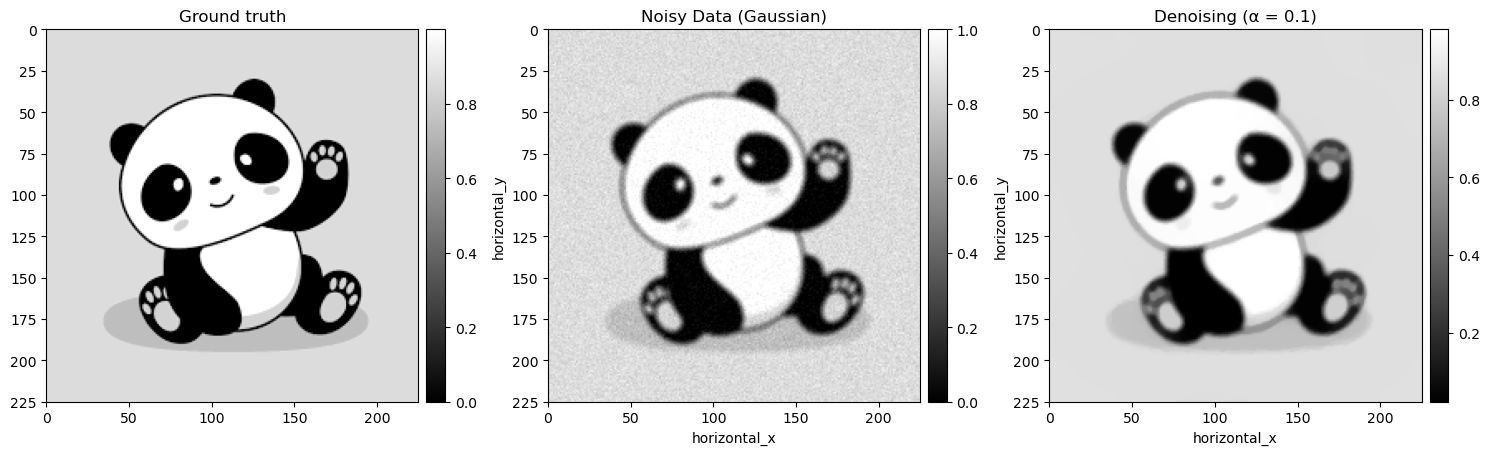

In [53]:
show2D([im_gray, im_blur_noise_gaussian, proxTV_3], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising (\u03B1 = 0.1)'], 
       origin="upper", num_cols=3)

When $\alpha$ is big;

In [54]:
alpha = 10
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_4 = TV.proximal(im_blur_noise_gaussian, tau=1)

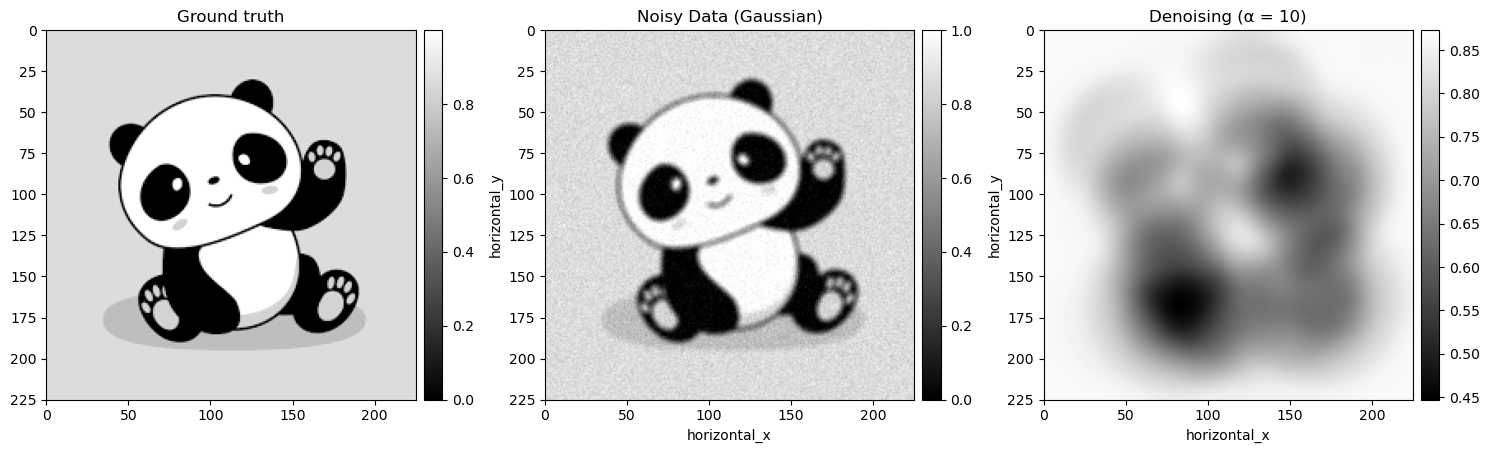

In [55]:
show2D([im_gray, im_blur_noise_gaussian, proxTV_4], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising (\u03B1 = 10)'], 
       origin="upper", num_cols=3)

When $\alpha$ is so big;

In [56]:
alpha = 1000
TV = alpha * TotalVariation(max_iteration=100, backend='numpy')
proxTV_5 = TV.proximal(im_blur_noise_gaussian, tau=1)

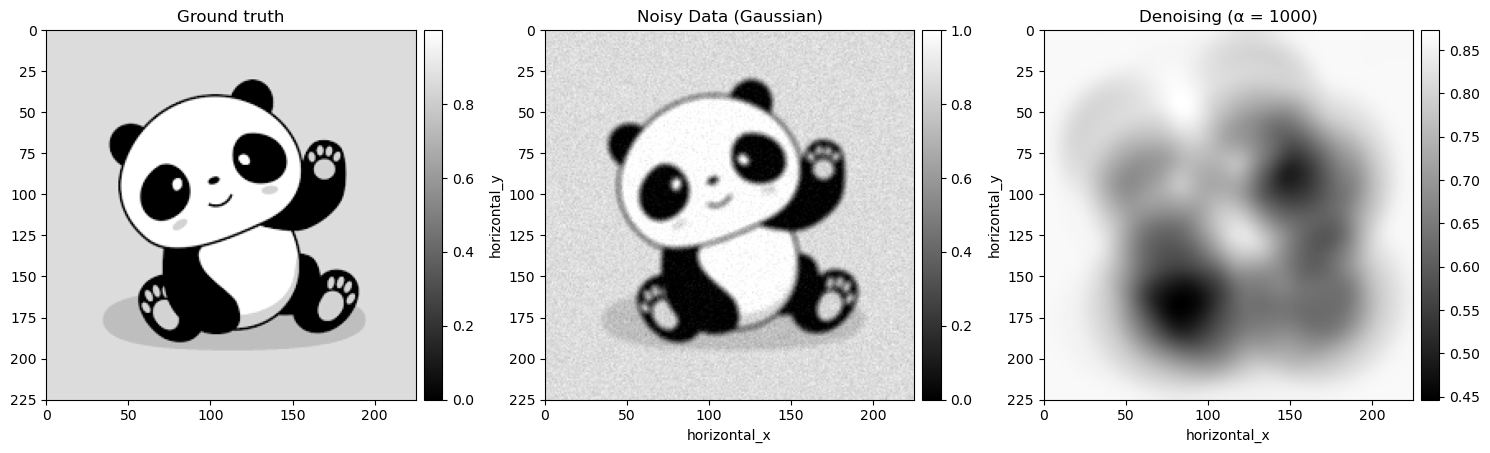

In [57]:
show2D([im_gray, im_blur_noise_gaussian, proxTV_5], 
       title=['Ground truth', 'Noisy Data (Gaussian)', 'Denoising (\u03B1 = 1000)'], 
       origin="upper", num_cols=3)

Overall, we can see that when $\alpha$ is big, all the details and lines disappear. However, when $\alpha$ is small, noise doesn't disappear.

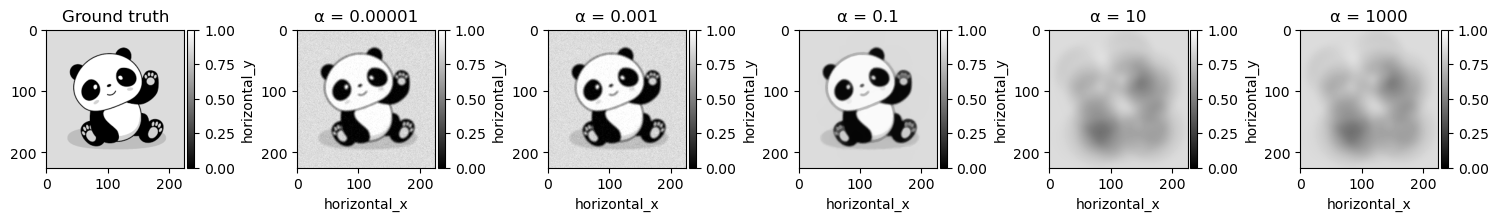

In [58]:
show2D([im_gray,proxTV_1, proxTV_2, proxTV_3, proxTV_4, proxTV_5], 
       title=['Ground truth', '\u03B1 = 0.00001','\u03B1 = 0.001', '\u03B1 = 0.1', '\u03B1 = 10', '\u03B1 = 1000'], 
       origin="upper", num_cols=6, fix_range = (0,1))